In [1]:
projectdir = "C:/Users/ArmanAngaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(pwd())

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, CSV, Pipe, ProgressMeter, StatsPlots
using Distributions, NLsolve, Roots
pyplot()

try
    Turnover
catch e
    include(projectdir*"Turnover/Turnover.jl")
    include(projectdir*"Turnover/test.jl")
    using .Turnover
end
try
    SeqDataFormatting
catch e
    include("experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end

import TumorGrowth
include("distribution_functions.jl")
plot(size=(1,1))

  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1317
┌ Info: Precompiling Roots [f2b01f46-fcfa-551c-844a-d8ac1e96c665]
└ @ Base loading.jl:1317


Test Summary:             | Pass  Total
Applying turnover methods |    7      7


# Ling Data

In [2]:
sanger = TumorGrowth.data_import("experimental_data/LingProcessed/experimental_data_Sanger.csv"; delim="\t")
sanger.frequencies = [ones(Float64, length(m)) for m in sanger.mutations];

In [4]:
wes = TumorGrowth.data_import("experimental_data/LingProcessed/experimental_data_WES.csv", delim="\t");

### Sanger: *sanger 'frequencies'*

In [6]:
# offspring_clade_fit, orphaned_clade_fit = [0, 2.0721200281841874], [0, 1.95984197842931]
# offspring_clone_fit, estranged_clone_fit = [0, 2.521358909445503], [0, 3.306604792822085]

# n 285, Nthresh_orph 285, Nthresh_estr 50, res 1/285, 1/3, sangerlike-freqs (samplenumbers)

offspring_clade_fit, orphaned_clade_fit, offspring_clone_fit, estranged_clone_fit = [0,1],[0,1],[0,1],[0,1]

function correct_orph(df_orph, p = [offspring_clade_fit, orphaned_clade_fit])
    max(0, sum(df_orph.isorphaned)- p[2][1]) / p[2][2] / max(0, sum(df_orph.isgreen) - p[1][1]) * p[1][2]
end
function correct_estr(df_estr, p = [offspring_clone_fit, estranged_clone_fit])
    max(0, sum(df_estr.isestranged)- p[2][1]) / p[2][2] / max(0, sum(df_estr.isgreen) - p[1][1]) * p[1][2]
end

correct_estr (generic function with 2 methods)

> ***set thresholds***

In [6]:
tumor = deepcopy(sanger)
turnover_params = (
    Nthresh_orph = 270,
    Nthresh_estr = 30,
    )
freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict(df.mutation .=> df.frequency)
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )
;

> ***d solve***

In [249]:
# get d
W_l = orphaned_red_treeless(orphaned_tumor) |>
        df -> sum(df.isorphaned)/sum(df.isgreen) 

d_solve = min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)

0.7634211762270511

> ***μ solve***

In [250]:
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen) #|> mes2theory_estranged
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)

0.14033380148901153

> ***SFS prediction (solve)***

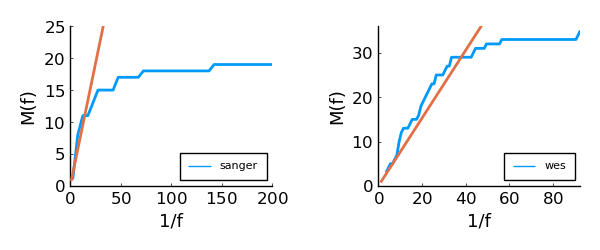

In [35]:
sanger_freqs = TumorGrowth.mutation_freqs(sanger).frequency
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,2), size=(600,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, :auto),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], sanger_freqs, nbins=50, lab="sanger", lw=2., ylim=(0,25), xlim=(0,200))
M!(p[2], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36))
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")
plot!(p[2], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

> ***d vary Nthresh***

0.7118667034197714


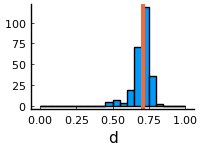

In [36]:
ds = map( 10:1:270) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    
    # get d
    W_l = orphaned_red_treeless(orphaned_tumor) |> 
        df -> sum(df.isorphaned)/sum(df.isgreen) 

    d_solve = min(1., 2*log(M)*W_l)
    end
histogram(ds, bins=0.:0.05:1., size=(200,150), lab="", xlab=:d)
println(median(ds))
vline!([median(ds)], lab="", lw=3., grid=false)

> ***μ (fit vs solve)***

mean fit : 0.16684702694952258
averaged fits : 0.16551522689853834 ± 0.0009998932404736388


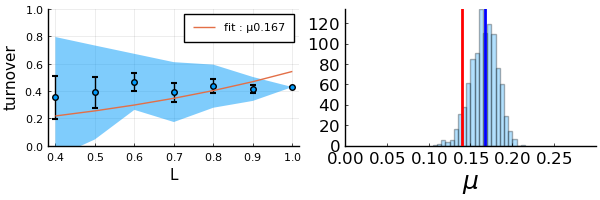

In [14]:
let d = d_solve
    Ls = 0.4:0.1:1.
    reps = 10
    estranged_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
    end

    estranged_turnover = map(estranged_tumors) do set
            filter!(!isnan, map(set) do tumor
                res = estranged_treeless(tumor)
                sum(res.isestranged)/sum(res.isgreen)
                end ) #|> mes2theory_estranged
        end

    Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
    
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr])/(1-d)))
        end
    end
    fitres = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fitres.param[1]

#     p = plot(layout=(1,2), size=(800, 250), margin=5Plots.mm)
    p1 = scatter( Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:topright, ylim=(0,1))
    plot!(Ls, model(Ls, fitres.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram( mu_fits, lab="", alpha=0.3, xlim=(0,0.3), nbins=20, size=(400,250), ylim=(0,:auto))
    vline!([mu_fit], lab="", lw=2., c=:blue, tickfontsize=12, labelfontsize=18, xlab=L"\mu", grid=false )
    vline!([mu_solve], lab="", lw=2., c=:red)

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1,p2, size=(600,200))
    
#     savefig("Turnover/turnover_plots/experimental_data/sanger_sangerfreqs_mu.pdf")
end

> ***summary (use median vals)***

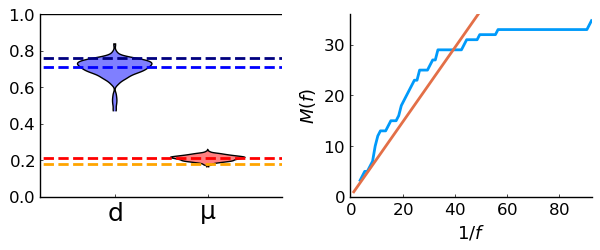

In [30]:
ds = map( 10:1:270) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    
    # get d
    W_l = orphaned_red_treeless(orphaned_tumor) |>
            df -> sum(df.isorphaned)/sum(df.isgreen) 

    d_solve = min(1., 2*log(M)*W_l)
    end
d_solve_mean = median(ds)
d_solve = last(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve_mean; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve_mean; b=1., μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 10
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen)
            end )
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve_mean; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))
    end
end
fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve_mean)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve_mean)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1)


p = plot(layout=(1,2), size=(600,250), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
# scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve_mean], c=:blue, lw=2., style=:dash)
hline!(p[1], [d_solve], c=:navyblue, lw=2., style=:dash)

violin!(p[1], [2], mu_fits, c=:red, fillalpha=0.5)
# scatter!(p[1], [2], mu_fits, c=:red, alpha=0.5)
hline!(p[1], [median(mu_fits)], c=:red, lw=2., style=:dash)
hline!(p[1], [mu_solve], c=:orange, lw=2., style=:dash)

wesfreqs = SeqDataFormatting.mfreqs(wes).frequency

res = 1/400
plot!(p[2], tickfontsize=12, labelfontsize=13)
M!(p[2], filter( f-> 1 > f > res, wesfreqs), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, :auto), ylim=(0,:36))
plot!(p[2], 1:80, x-> x*median(mu_fits)/(1-d_solve_mean), lw=2., lab="")

In [ ]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)
    end
end
filter!.(!isnan, ds)
ds = vcat(ds...)
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1)


p = plot(layout=(1,2), size=(600,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

violin!(p[1], [2], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[1], [2], mu_fits, c=:red, alpha=0.5)
hline!(p[1], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits))
hline!(p[1], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/400
plot!(p[2], tickfontsize=12, labelfontsize=13)
M!(p[2], filter( f-> 1 > f > res, collect(values(freqs))), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, :auto), ylim=(0,40))
plot!(p[2], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

In [127]:
# savefig("Turnover/turnover_plots/experimental_data/sanger_sangerfreqs.pdf")

### Sanger: *wes frequencies*

In [5]:
# offspring_clade_fit, orphaned_clade_fit = [0, 0.3694065504550832], [0, 0.9337963349045757]
# offspring_clone_fit, estranged_clone_fit = [0, 0.27062540749285335], [0, 0.3815998563513362]

# n 30, Nthresh_orph 200, Nthresh_estr 50, res 1/200, 1/3

offspring_clade_fit, orphaned_clade_fit, offspring_clone_fit, estranged_clone_fit = [0,1],[0,1],[0,1],[0,1]

function correct_orph(df_orph, p = [offspring_clade_fit, orphaned_clade_fit])
    max(0, sum(df_orph.isorphaned)- p[2][1]) / p[2][2] / max(0, sum(df_orph.isgreen) - p[1][1]) * p[1][2]
end
function correct_estr(df_estr, p = [offspring_clone_fit, estranged_clone_fit])
    max(0, sum(df_estr.isestranged)- p[2][1]) / p[2][2] / max(0, sum(df_estr.isgreen) - p[1][1]) * p[1][2]
end

correct_estr (generic function with 2 methods)

In [6]:
turnover_params = ( Nthresh_orph = 35, Nthresh_estr = 20, )

freqs = SeqDataFormatting.mfreqs(wes) |> df -> Dict(df.mutation .=> df.frequency)
mutations = filter(m -> freqs[m] > 1/100, unique(vcat(wes.mutations...)) )

tumor = deepcopy(sanger)
filter!.(m -> m in mutations, tumor.mutations);

In [10]:
# scaleby = 100_000

100000

#### single call

In [7]:
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
    
# get d
W_l = orphaned_red_treeless(orphaned_tumor) |> 
    df -> sum( df.isorphaned ) / sum( df.isgreen )

d_solve = min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)

0.8888370153723534

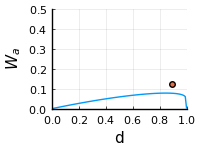

In [49]:
plot(0:0.01:1., x -> Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph]/(1-x) ), xlim=(0,1), ylim=(0,0.5), size=(200,150), lab=:none)
scatter!([d_solve], [W_l], lab=:none, xlab=:d, ylab=L"W_a")

In [22]:
d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph])) - W_l, 0.01, 0.99) 

0.8895631894045203

In [140]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)

0.044997641095204995

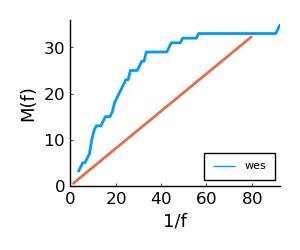

In [141]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, :auto),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36))
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

#### vary samplesize

0.7188470821763525


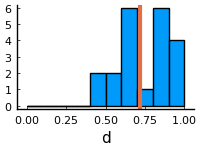

In [142]:
ds = map( 20:1:40) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    
    # get d
    W_l = orphaned_red_treeless(orphaned_tumor) |> 
        df -> sum( df.isorphaned ) / sum( df.isgreen )

    d_solve = min(1., 2*log(M)*W_l)
end
println(median(ds))
histogram(ds, bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(ds)], lab="", lw=3., grid=false, xlab=:d)

1.0


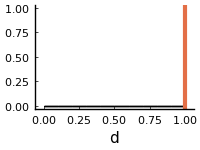

In [71]:
ds = map( 20:1:40) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    
    # get d
    W_l = orphaned_red_treeless(orphaned_tumor) |> 
        df -> sum( df.isorphaned ) / sum( df.isgreen )
    d_solve = try
        fzero(x -> min(1., Turnover.W_orphaned( x; N= M / (1-x) )) - W_l, 0.01, 0.99)
    catch e
        e isa ArgumentError && 1.
    end
end
println(median(ds))
histogram(ds, bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(ds)], lab="", lw=3., grid=false, xlab=:d)

0.3645544303038035


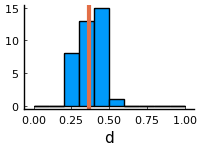

In [13]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph] / (1-x) )) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
println(median(vcat(ds...)))
histogram(vcat(ds...), bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(vcat(ds...))], lab="", lw=3., grid=false, xlab=:d)

0.8888370153723534


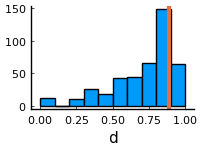

In [10]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)
    end
end
filter!.(!isnan, ds)
println(median(vcat(ds...)))
histogram(vcat(ds...), bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(vcat(ds...))], lab="", lw=3., grid=false, xlab=:d)

In [14]:
d_solve=0.88

0.88

In [145]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)

0.04896213418669734

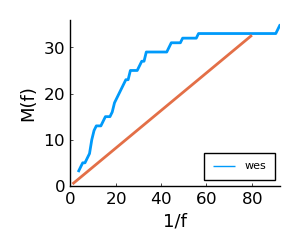

In [16]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, :auto),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36))
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

In [18]:
ds = map( 0.5:0.1:1. ) do L
   map( 1:10 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph] / (1-x) )) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && 1.
        end
    end
end

6-element Vector{Vector{Float64}}:
 [0.4343345593676229, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4999019658819744]
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.4488854153503258, 1.0, 1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

0.385349070906583


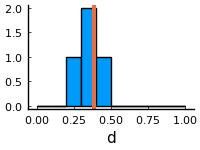

In [77]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:10 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph] / (1-x) )) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
println(median(vcat(ds...)))
histogram(vcat(ds...), bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(vcat(ds...))], lab="", lw=3., grid=false, xlab=:d)

In [78]:
d_solve=0.38

0.38

In [82]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)^2))- W_c, 0.01, 0.99)

0.4041016388175295

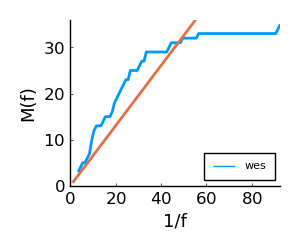

In [83]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, :auto),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36))
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

mean fit : 0.05817285784850992
averaged fits : 0.05660048220920789 ± 0.0008177472886175226


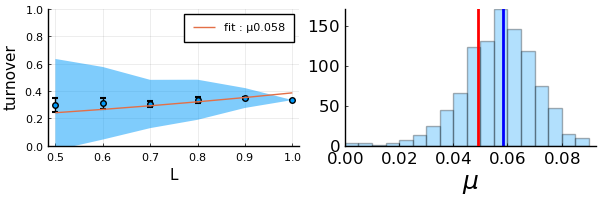

In [148]:
let d = d_solve
    Ls = 0.5:0.1:1.
    reps = 50
    estranged_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
    end

    estranged_turnover = map(estranged_tumors) do set
            filter!(!isnan, map(set) do tumor
                res = estranged_treeless(tumor)
                sum( res.isestranged ) / sum( res.isgreen )
                end ) 
        end

    Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
    
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr])/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fit.param[1]

    p1 = scatter( Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:topright, ylim=(0,1))
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram( mu_fits, lab="", alpha=0.3, xlim=(0,:auto), nbins=30, size=(400,250), ylim=(0,:auto))
    vline!([mu_fit], lab="", lw=2., c=:blue, tickfontsize=12, labelfontsize=18, xlab=L"\mu", grid=false )
    vline!([mu_solve], lab="", lw=2., c=:red)

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1,p2, size=(600,200))

#     savefig("Turnover/turnover_plots/experimental_data/sanger_wesfreqs_mu.pdf")
end

0.7188470821763525
0.15527818189758016


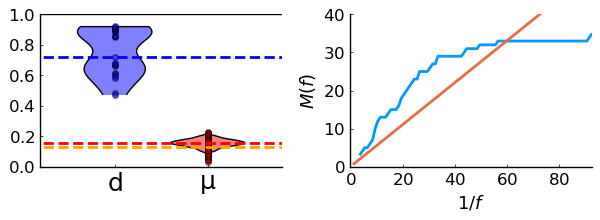

In [149]:
ds = map( 20:1:40) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    # get d
    W_l = orphaned_tumor |> orphaned_red_treeless |> df -> sum( df.isorphaned ) / sum( df.isgreen ) #|> mes2theory_orphaned

    min(1., 2*log(M)*W_l)
end
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1)


p = plot(layout=(1,2), size=(600,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

violin!(p[1], [2], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[1], [2], mu_fits, c=:red, alpha=0.5)
hline!(p[1], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits))
hline!(p[1], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/400
plot!(p[2], tickfontsize=12, labelfontsize=13)
M!(p[2], filter( f-> 1 > f > res, collect(values(freqs))), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, :auto), ylim=(0,40))
plot!(p[2], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

0.8888370153723534
0.05285416716137777


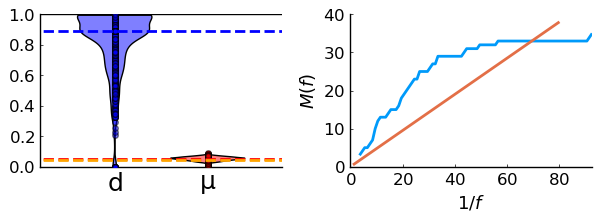

In [150]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)
    end
end
filter!.(!isnan, ds)
ds = vcat(ds...)
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1)


p = plot(layout=(1,2), size=(600,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

violin!(p[1], [2], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[1], [2], mu_fits, c=:red, alpha=0.5)
hline!(p[1], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits))
hline!(p[1], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/400
plot!(p[2], tickfontsize=12, labelfontsize=13)
M!(p[2], filter( f-> 1 > f > res, collect(values(freqs))), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, :auto), ylim=(0,40))
plot!(p[2], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

In [20]:
# savefig("Turnover/turnover_plots/experimental_data/sanger_wesfreqs_varyL.pdf")

# Original Wes data

In [212]:
wes_init = TumorGrowth.data_import("experimental_data/LingProcessed/experimental_data_WES.csv", delim="\t");

In [227]:
turnover_params = ( Nthresh_orph = 40, Nthresh_estr = 20, )
filter_params =  (cutoff_low = 1/80, sample_cutoff_low = 1/3, )
mutnumb = 20

wes = deepcopy(wes_init)
filter_by_freq!(wes; filter_params...)
subsample!(wes; nmuts = mutnumb)
freqs = SeqDataFormatting.mfreqs(wes) |> df -> Dict( df.mutation .=> df.frequency);

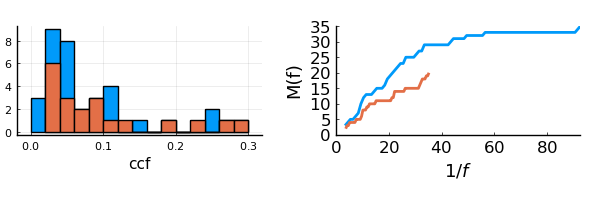

In [228]:
freqs_init = SeqDataFormatting.mfreqs(wes_init).frequency

p = plot(layout=(1,2), size=(600,200))
histogram!(p[1], filter( f-> 0.8 > f, freqs_init), nbins=20, lab="", xlab=:ccf)
M!(p[2], filter( f-> 0.8 > f > res, freqs_init), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, margin=5Plots.mm, lw=2., xlim=(0, :auto), ylim=(0,length(mutations)))


histogram!(p[1], filter( f-> 0.8 > f, collect(values(freqs))), nbins=20, lab="", xlab=:ccf)
M!(p[2], filter( f-> 0.8 > f > res, collect(values(freqs))), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, margin=5Plots.mm, lw=2., xlim=(0, :auto), ylim=(0,length(mutations)))

In [229]:
htypes = unique(wes.mutations)
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], htypes) ) )
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), htypes) )

# get d
W_l = orphaned_red_treeless(orphaned_tumor) |>
        df -> sum(df.isorphaned)/sum(df.isgreen)

d_solve = min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)

1.0

0.8401784006787216


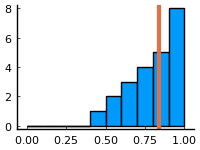

In [230]:
ds = map( 5:1:turnover_params[:Nthresh_orph]) do M
    # get d
    W_l = orphaned_red_treeless(orphaned_tumor) |>
        df -> sum(df.isorphaned)/sum(df.isgreen)

    min(1., 2*log(M)*W_l)
end
d_median_filtered = filter(!isone, ds) |> median
println(d_median_filtered)
histogram(ds, bins=0.:0.1:1., size=(200,150), lab="")
vline!([d_median_filtered], lab="", lw=3., grid=false)

In [231]:
d_solve = 0.84

0.84

In [232]:
# get mu

Ls = 0.5:0.1:1.
reps = 10
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen)
        end )
    end

Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1, μ=mu*L, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))
    end
end

fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
mu_fit = fitres.param[1]

0.14580170685389374

In [233]:
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen)

mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
# mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr]))/(1-d_solve))- W_c, 0.01, 0.99)

(0.13544028820935639, 32)

mean fit : 0.14580170685371105
averaged fits : 0.15011107933114853 ± 0.0018314936868580327


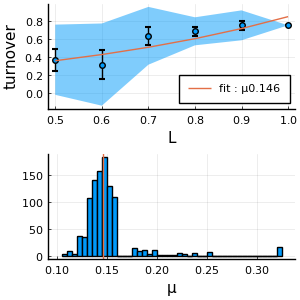

In [234]:
let d = d_solve
    t = estranged_turnover
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr])/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [0.001])
    mu_fit = fit.param[1]

    p1 = scatter(Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:bottomright)
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram(mu_fits, xlab="μ", lab="")
    vline!([mu_fit], lab="")

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1, p2, layout=(2,1), size=(300,300))
end

In [237]:
mu_solve = 0.14

0.14

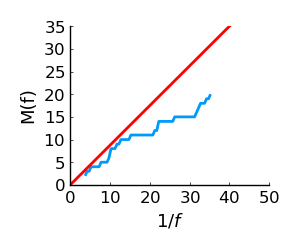

In [238]:
M(filter( f-> 0.8 > f, collect(values(freqs))), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, margin=5Plots.mm, lw=2., xlim=(0, :auto), ylim=(0,length(mutations)), size=(300,250))
plot!(0:50, x-> x*mu_solve/(1-d_solve), lab="", c=:red, lw=2.)

### vary μ

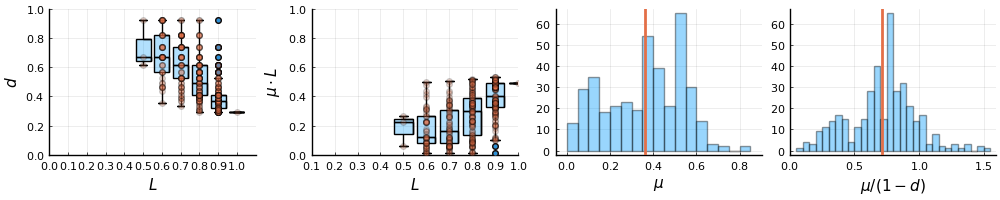

In [195]:
params = (
    Nthresh_orph =40,
    Nthresh_estr = 20,
    res = 1/80,
    )

mutations = vcat(sanger.mutations...) |> unique
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.frequencies[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )
results = Vector()
Ls = Float64[]
for L = 0.5:0.1:1.
    for _=1:200
        tumor = deepcopy(select(sanger, :mutations))
        
        selection = sample(mutations, floor(Int, length(mutations)*L), replace =false)
        filter!.(m -> m in selection, tumor.mutations)
        
#         freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)
        
        filter!.(m-> 1.1 > freqs[m] > params[:res], tumor.mutations)

        htypes = unique(tumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/params[:Nthresh_orph], htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), htypes) )

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
            df -> sum(df.isorphaned)/sum(df.isgreen) 
        
        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        
        (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> 
            df -> sum(df.isestranged)/sum(df.isgreen) 
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve ≈ 0.99 && continue
            
            push!(results, (d_solve, mu_solve))
            push!(Ls, L)
            L==1. && break
            catch e
        end
        
    end
end
p = plot(layout=(1,4), legend=:none, size=(1000,200))
scalex = 10

boxplot!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"d")
# hline!(p[1], [mean(getindex.(results, 1))], lw=2.)

boxplot!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(4,scalex), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
# plot!(p[2], [0,scalex], [0,last(results)[2]], lw=2.)

histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )

slope = filter(x -> x< 4, getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))

histogram!(p[4], slope, xlim=(0,:auto), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
vline!(p[4], [mean(slope)], lw=2. )

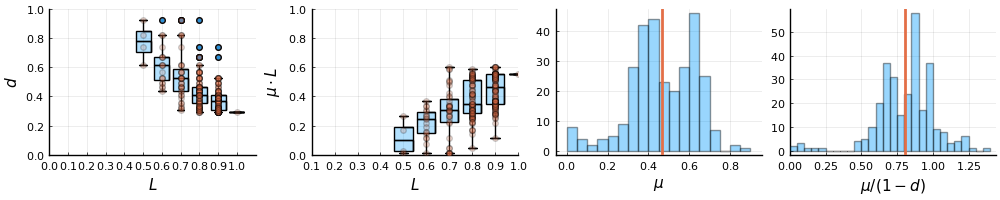

In [198]:
params = (
    Nthresh_orph =40,
    Nthresh_estr = 15,
    res = 1/80,
    )

mutations = vcat(sanger.mutations...) |> unique
freqs = Dict( mutations .=> map( mutations ) do m
    2*mean( m in cell.mutations ? cell.frequencies[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(wes) )
        end / mean(wes.purity) )
results = Vector()
Ls = Float64[]
for L = 0.5:0.1:1.
    for _=1:200
        tumor = deepcopy(select(sanger, :mutations))
        
        selection = sample(mutations, floor(Int, length(mutations)*L), replace =false)
        filter!.(m -> m in selection, tumor.mutations)
        
#         freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)
        
        filter!.(m-> 1.1 > freqs[m] > params[:res], tumor.mutations)

        htypes = unique(tumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/params[:Nthresh_orph], htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), htypes) )

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum(df.isorphaned)/sum(df.isgreen) 
        
        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        
        (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> 
            df -> sum(df.isestranged)/sum(df.isgreen) 
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve ≈ 0.99 && continue
            
            push!(results, (d_solve, mu_solve))
            push!(Ls, L)
            L==1. && break
            catch e
        end
        
    end
end
p = plot(layout=(1,4), legend=:none, size=(1000,200))
scalex = 10

boxplot!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"d")
# hline!(p[1], [mean(getindex.(results, 1))], lw=2.)

boxplot!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(4,scalex), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
# plot!(p[2], [0,scalex], [0,last(results)[2]], lw=2.)

histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )

slope = filter(x -> x< 4, getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))

histogram!(p[4], slope, xlim=(0,:auto), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
vline!(p[4], [mean(slope)], lw=2. )

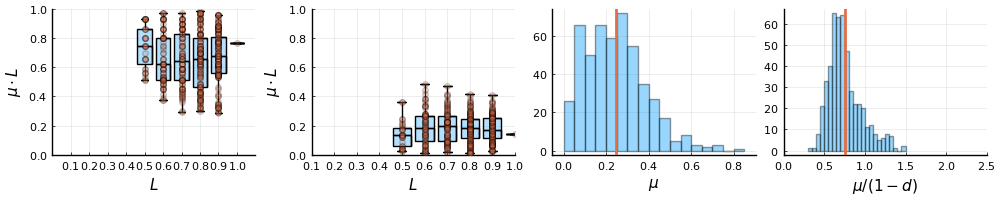

In [199]:
params = (
    Nthresh_orph = 270,
    Nthresh_estr = 30,
    res = 1/270,
    )

mutations = vcat(sanger.mutations...) |> unique
results = Vector()
Ls = Float64[]
for L = 0.5:0.1:1.
    for _=1:200
        tumor = deepcopy(select(sanger, :mutations))
        
        selection = sample(mutations, floor(Int, length(mutations)*L), replace =false)
        filter!.(m -> m in selection, tumor.mutations)
        
        freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)
        
        filter!.(m-> 1.1 > freqs[m] > params[:res], tumor.mutations)

        htypes = unique(tumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/params[:Nthresh_orph], htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/params[:Nthresh_estr] for m in muts), htypes) )

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen) #|> mes2theory_orphaned
        
        d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        
        (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen) #|> mes2theory_estranged
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve ≈ 0.99 && continue
            
            push!(results, (d_solve, mu_solve))
            push!(Ls, L)
            L==1. && break
            catch e
        end
        
    end
end
p = plot(layout=(1,4), legend=:none, size=(1000,200))
scalex = 10

boxplot!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
# hline!(p[1], [mean(getindex.(results, 1))], lw=2.)

boxplot!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(4,scalex), ylim=(0,1), xlab = L"L", ylab=L"\mu\cdot L")
# plot!(p[2], [0,scalex], [0,last(results)[2]], lw=2.)

histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )
histogram!(p[4], getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)), xlim=(0,2.5), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
vline!(p[4], [mean(getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))], lw=2. )